In [407]:
import pandas as pd

df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00397/LasVegasTripAdvisorReviews-Dataset.csv", sep=';')

In [408]:
df.head()

,User country,Nr. reviews,Nr. hotel reviews,Helpful votes,Score,Period of stay,Traveler type,Pool,Gym,Tennis court,Spa,Casino,Free internet,Hotel name,Hotel stars,Nr. rooms,User continent,Member years,Review month,Review weekday
0,USA,11,4,13,5,Dec-Feb,Friends,NO,YES,NO,NO,YES,YES,Circus Circus Hotel & Casino Las Vegas,3,3773,North America,9,January,Thursday
1,USA,119,21,75,3,Dec-Feb,Business,NO,YES,NO,NO,YES,YES,Circus Circus Hotel & Casino Las Vegas,3,3773,North America,3,January,Friday
2,USA,36,9,25,5,Mar-May,Families,NO,YES,NO,NO,YES,YES,Circus Circus Hotel & Casino Las Vegas,3,3773,North America,2,February,Saturday
3,UK,14,7,14,4,Mar-May,Friends,NO,YES,NO,NO,YES,YES,Circus Circus Hotel & Casino Las Vegas,3,3773,Europe,6,February,Friday
4,Canada,5,5,2,4,Mar-May,Solo,NO,YES,NO,NO,YES,YES,Circus Circus Hotel & Casino Las Vegas,3,3773,North America,7,March,Tuesday


In [409]:
df['Score'].value_counts(normalize=True)

5    0.450397
4    0.325397
3    0.142857
2    0.059524
1    0.021825
Name: Score, dtype: float64

In [410]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, train_size=0.80, test_size=0.20, stratify=df['Score'], random_state=1337)

In [411]:
train['Score'].value_counts(normalize=True)

5    0.449132
4    0.325062
3    0.143921
2    0.059553
1    0.022333
Name: Score, dtype: float64

In [412]:
def wrangle(X, predict):

    X = X.copy()

    def country_aggregation(row): #reduce number of country categories to 4. 'USA', 'Canada', 'UK', and all else 'other'.
        if row['User country'] != "USA" and row['User country'] != 'Canada' and row['User country'] != 'UK':
            return "Other"
        else:
            return row['User country']

    def score_aggregation(row):
        if row['Score'] == 5:
            return "Excellent"
        elif row['Score'] == 4 or row['Score'] == 3:
            return "Average"
        else:
            return "Bad"

    X['User country'] = X.apply(country_aggregation, axis=1)

    if not predict: #only modify score column if passing in training/test data. Do not run when running real predictions!
        X['Score'] = X.apply(score_aggregation, axis=1)
        X = X.drop(['Member years'], axis=1)

    X['Hotel stars'] = X['Hotel stars'].str.replace("," , ".").astype(str)
    X['Hotel stars'] = X['Hotel stars'].replace({"3": 1, "3.5": 2, "4": 3, "4.5": 4, "5": 5}).astype(int) #ordinal encoding

    X.loc[(X['Hotel name'] == "Trump International Hotel Las Vegas") |  #Trump international is a hotel only, no casino.
          (X['Hotel name'] == "Marriott's Grand Chateau") | #Marriott's Grand Chateau is a hotel only, no casino.
          (X['Hotel name'] == "Wyndham Grand Desert"), 'Casino'] = "NO" #Wyndham Grand Desert is a hotel only, no casino.

    #X = X.drop(['Review month', 'Review weekday'], axis=1)

    return X

In [413]:
train = wrangle(train, predict=False)
test = wrangle(test, predict=False)

In [414]:
from sklearn.metrics import accuracy_score

majority_class = train['Score'].mode()[0]
y_pred = [majority_class] * len(train['Score'])

print("Train baseline accuracy is: ", accuracy_score(train['Score'], y_pred))

Train baseline accuracy is:  0.46898263027295284


In [415]:
majority_class = test['Score'].mode()[0]
y_pred = [majority_class] * len(test['Score'])

print("Test baseline accuracy is: ", accuracy_score(test['Score'], y_pred))

Test baseline accuracy is:  0.46534653465346537


In [416]:
target = 'Score'

train_features = train.drop([target], axis=1)
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

categorical_features = train_features.select_dtypes(exclude='number').nunique().index.tolist()


features = numeric_features + categorical_features

features_logistic = categorical_features.copy()
features_logistic.append('Hotel stars') #add hotel stars to features list, so we can specify to onehotencoder that we want to encode it, even though it is numeric(as we already did ordinal encoding on it)

In [417]:
y_train = train[target]
X_train = train[features]
X_test = test[features]
y_test = test[target]

In [418]:
X_train.shape

(403, 18)

In [419]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.preprocessing import StandardScaler
import category_encoders as ce
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from xgboost import XGBClassifier
from imblearn.over_sampling import RandomOverSampler

#When hyperparamater tuning, set tune to "True", and mark each model that we want to tune to "True".
tune = False
forest = True
logistic = True
xgboost = True

forest_distributions = {
    'model__n_estimators': range(250, 500, 50),
    'model__max_depth': range(3, 14),
    'model__max_features': range(2, 14),
    'model__min_samples_leaf': range(2, 4)
}
logistic_distributions = {
    'kbest__k': range(1, 20),
    'model__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

xgboost_distributions = {
    'model__n_estimators': [75, 100, 125, 150, 175],
    'model__max_depth': [6, 7, 8, 9, 10, 11, 12, 13],
    'model__learning_rate': [0.01, 0.02, 0.03, 0.04, 0.05, 0.07, 0.10, 0.12, 0.14, 0.16],
    'model__min_child_leaf':[1, 2, 3],
    'model__min_child_weight': [1, 2, 3, 4],
    'model__colsample_bytree':[0.2, 0.3, 0.4, 0.50, 0.60, 0.70],
    'model__subsample':[0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
    'model__gamma':[0],
    'model__scale_pos_weight': [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70,
                                75, 80, 85, 90, 95, 100]
 }

if tune: #If we are hyperparamater tuning, pass no parameters into estimators and find paramaters via GridSearchCV / RandomizedSearchCV

    forest_pipeline = Pipeline([('encoder', ce.OrdinalEncoder()),
                           ('model', RandomForestClassifier(random_state=1337))])

    logistic_pipeline = Pipeline([('encoder', ce.OneHotEncoder()),
                                ('scaler', StandardScaler()),
                                ('kbest', SelectKBest()),
                                ('model', LogisticRegression(random_state=1337))])

    xgboost_pipeline = Pipeline([('encoder', ce.OrdinalEncoder()),
                           ('model', XGBClassifier(seed=1337))])

    forest_search = GridSearchCV(
        forest_pipeline,
        param_grid=forest_distributions,
        cv=3,
        scoring='neg_log_loss',
        verbose=10,
        n_jobs=15
    )
    logistic_search = GridSearchCV(
        logistic_pipeline,
        param_grid=logistic_distributions,
        cv=3,
        scoring='neg_log_loss',
        verbose=10,
        n_jobs=15
    )
    xgboost_search = RandomizedSearchCV(
        estimator=xgboost_pipeline,
        param_distributions=xgboost_distributions,
        n_iter=10000,
        cv=3,
        scoring='neg_log_loss',
        verbose=10,
        random_state=1337,
        n_jobs=15
    )

    X_train, y_train = RandomOverSampler(sampling_strategy='not majority').fit_resample(X_train, y_train)

    if forest:
        forest_search.fit(X_train, y_train)
        forest_train_pred = forest_search.predict(X_train)
        forest_test_pred = forest_search.predict(X_test)
        forest_test_pred_proba = forest_search.predict_proba(X_test)

    if logistic:
        logistic_search.fit(X_train, y_train)
        logistic_train_pred = logistic_search.predict(X_train)
        logistic_test_pred = logistic_search.predict(X_test)
        logistic_pred_proba = logistic_search.predict_proba(X_test)

    if xgboost:
        xgboost_search.fit(X_train, y_train)
        xgboost_train_pred = xgboost_search.predict(X_train)
        xgboost_test_pred = xgboost_search.predict(X_test)
        xgboost_test_pred_proba = xgboost_search.predict_proba(X_test)

    #When hyperparameter tuning, pass our best estimators into votingclassifier. Only run when all 3 models are being tuned.
    if forest and logistic and xgboost:
        voting_model = VotingClassifier(estimators=[('forest', forest_search.best_estimator_), #VotingClassifier is Soft Voting/Majority Rule classifier for unfitted estimators
                                                    ('logistic', logistic_search.best_estimator_),
                                                    ('xgboost', xgboost_search.best_estimator_),],
                                        voting='soft', weights=[2, 1, 2]) #soft voting per recommendation from sklearn documentation, when used on tuned classifiers.
        voting_model.fit(X_train, y_train)

else: #If we are not hyperparameter tuning, pass in our best params(from previous tuning runs).
    forest_pipeline = Pipeline([('encoder', ce.OrdinalEncoder()),
                            ('model', RandomForestClassifier(random_state=1337,
                                                        max_depth=13,
                                                        max_features=11,
                                                        min_samples_leaf=2,
                                                        n_estimators=450))])
    logistic_pipeline = Pipeline([('encoder', ce.OneHotEncoder(cols=features_logistic)),
                                ('scaler', StandardScaler()),
                                ('kbest', SelectKBest(k=19)),
                                ('model', LogisticRegression(random_state=1337, C=0.01))])

    xgboost_pipeline = Pipeline([('encoder', ce.OrdinalEncoder()),
                                ('model', XGBClassifier(random_state=1337, n_estimators=175, min_child_weight=1,
                                                min_child_leaf=2, max_depth=11, learning_rate=0.04,
                                                gamma=0, subsample=0.8, colsample_bytree=0.3, scale_pos_weight=100))])


    X_train, y_train = RandomOverSampler(sampling_strategy='not majority').fit_resample(X_train, y_train) #over sample all but the majority class

    forest_pipeline.fit(X_train, y_train)
    forest_train_pred = forest_pipeline.predict(X_train)
    forest_test_pred = forest_pipeline.predict(X_test)
    forest_test_pred_proba = forest_pipeline.predict_proba(X_test)

    logistic_pipeline.fit(X_train, y_train)
    logistic_train_pred = logistic_pipeline.predict(X_train)
    logistic_test_pred = logistic_pipeline.predict(X_test)
    logistic_test_pred_proba = logistic_pipeline.predict_proba(X_test)

    xgboost_pipeline.fit(X_train, y_train)
    xgboost_train_pred = xgboost_pipeline.predict(X_train)
    xgboost_test_pred = xgboost_pipeline.predict(X_test)
    xgboost_test_pred_proba = xgboost_pipeline.predict_proba(X_test)

    voting_model = VotingClassifier(estimators=[('forest', forest_pipeline), #VotingClassifier is Soft Voting/Majority Rule classifier for unfitted estimators
                                                ('logistic', logistic_pipeline),
                                                ('xgboost', xgboost_pipeline),],
                                    voting='soft') #soft voting per recommendation from sklearn documentation, when used on tuned classifiers.
    voting_model.fit(X_train, y_train)

In [420]:
from joblib import dump
dump(voting_model, 'voting_model.joblib', compress=True)

['voting_model.joblib']

In [421]:
import joblib
import sklearn
import category_encoders as ce
import xgboost
import imblearn
print(f'joblib=={joblib.__version__}')
print(f'scikit-learn=={sklearn.__version__}')
print(f'category_encoders=={ce.__version__}')
print(f'xgboost=={xgboost.__version__}')
print(f'imblearn=={imblearn.__version__}')



joblib==0.14.1
scikit-learn==0.22.2.post1
category_encoders==2.1.0
xgboost==1.0.2
imblearn==0.6.2


In [422]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, plot_roc_curve
if tune:
    target_names = ['Average', 'Bad', 'Excellent']

    if forest:
        print(forest_search.best_params_, '\n')
        print("Best Random Forest CV score: ", forest_search.best_score_, '\n')
        print("Random forest ROC-AUC: ", roc_auc_score(y_test, forest_test_pred_proba, multi_class='ovr', labels=target_names), '\n')
        print(classification_report(y_test, forest_test_pred, target_names=target_names), '\n')

        print('\n')

    if logistic:
        print(logistic_search.best_params_, '\n')
        print("Best logistic regression CV score: ", logistic_search.best_score_, '\n')
        print("Logistic regression ROC-AUC: ", roc_auc_score(y_test, logistic_test_pred_proba, multi_class='ovr', labels=target_names), '\n')
        print(classification_report(y_test, logistic_test_pred, target_names=target_names), '\n')

        print('\n')

    if xgboost:
        print(xgboost_search.best_params_, '\n')
        print("Best xgboost CV score: ", xgboost_search.best_score_, '\n')
        print("Xgboost ROC-AUC: ", roc_auc_score(y_test, xgboost_test_pred_proba, multi_class='ovr', labels=target_names), '\n')
        print(classification_report(y_test, xgboost_test_pred, target_names=target_names), '\n')

        print('\n')

    if forest and logistic and xgboost:
        print("Voting classifier, final accuracy score on test set: ", voting_model.score(X_test, y_test))

        combined_model = voting_model.predict_proba(X_test)
        print("Voting classifier, final ROC AUC on test set: ", roc_auc_score(y_test, combined_model, multi_class='ovr', labels=target_names))
else:
    target_names = ['Average', 'Bad', 'Excellent']
    print("Random forest ROC-AUC: ", roc_auc_score(y_test, forest_test_pred_proba, multi_class='ovr', labels=target_names), '\n')
    print(classification_report(y_test, forest_test_pred, target_names=target_names))

    print('\n')

    print("Logistic regression ROC-AUC: ", roc_auc_score(y_test, logistic_test_pred_proba, multi_class='ovr', labels=target_names), '\n')
    print(classification_report(y_test, logistic_test_pred, target_names=target_names))

    print('\n')

    print("Xgboost ROC-AUC: ", roc_auc_score(y_test, xgboost_test_pred_proba, multi_class='ovr', labels=target_names), '\n')
    print(classification_report(y_test, xgboost_test_pred, target_names=target_names))

    print('\n')

    print("Voting classifier, final accuracy score on test set: ", voting_model.score(X_test, y_test))

    combined_model = voting_model.predict_proba(X_test)
    print("Voting classifier, final ROC AUC on test set: ", roc_auc_score(y_test, combined_model, multi_class='ovr', labels=target_names))

Random forest ROC-AUC:  0.7089833954383405 

              precision    recall  f1-score   support

     Average       0.57      0.60      0.58        47
         Bad       0.33      0.38      0.35         8
   Excellent       0.53      0.50      0.52        46

    accuracy                           0.53       101
   macro avg       0.48      0.49      0.48       101
weighted avg       0.54      0.53      0.53       101



Logistic regression ROC-AUC:  0.6191013974639749 

              precision    recall  f1-score   support

     Average       0.63      0.36      0.46        47
         Bad       0.13      0.38      0.19         8
   Excellent       0.55      0.61      0.58        46

    accuracy                           0.48       101
   macro avg       0.44      0.45      0.41       101
weighted avg       0.55      0.48      0.49       101



Xgboost ROC-AUC:  0.6911964959091277 

              precision    recall  f1-score   support

     Average       0.58      0.64      0.61 

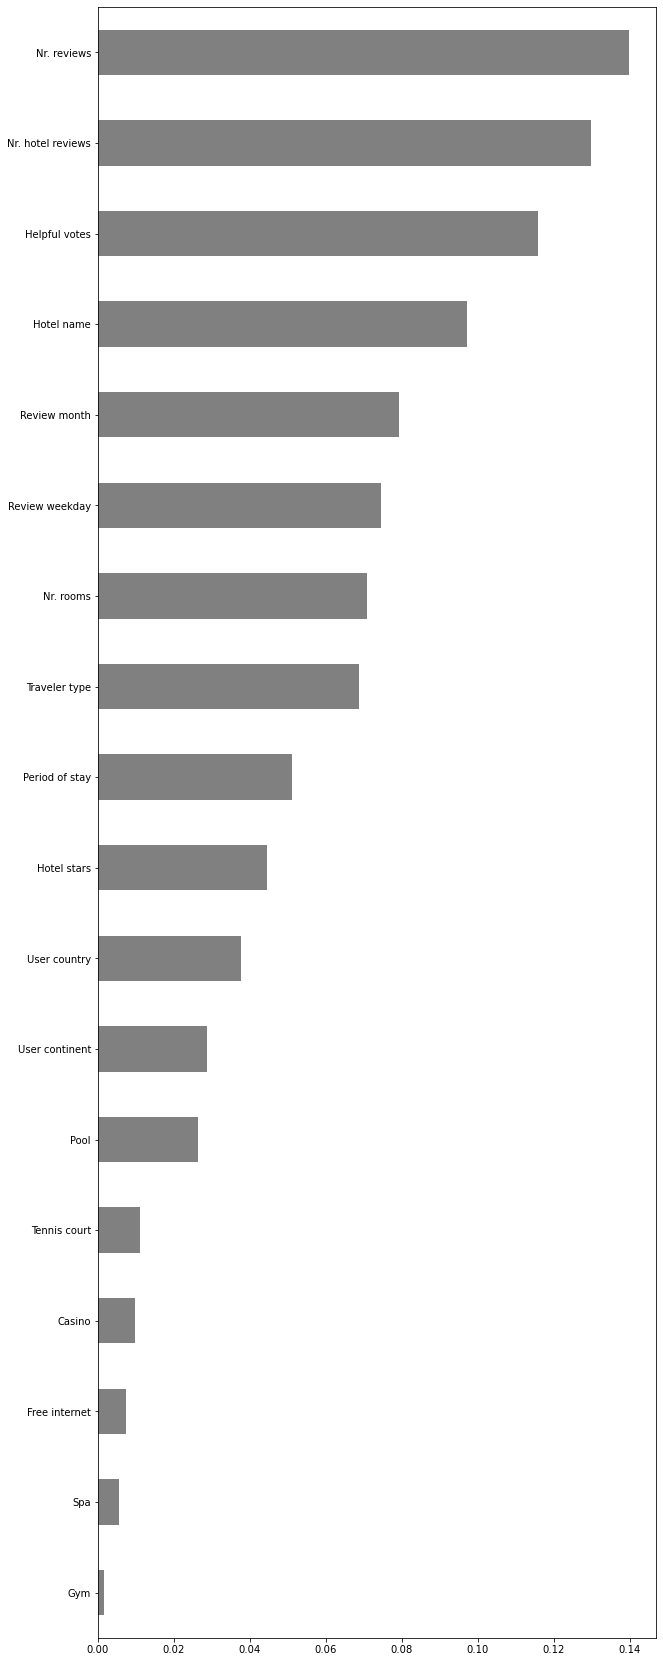

In [423]:
import matplotlib.pyplot as plt

if tune:
    model = forest_search.best_estimator_.named_steps.model
    encoder = forest_search.best_estimator_.named_steps.encoder
else:
    model = forest_pipeline.named_steps.model
    encoder = forest_pipeline.named_steps.encoder


encoded_columns = encoder.transform(X_test).columns
importances = pd.Series(model.feature_importances_, encoded_columns)
plt.figure(figsize=(10,30))
importances.sort_values().plot.barh(color='grey');

In [424]:
# import matplotlib.pyplot as plt
#
# import seaborn as sns
# plt.figure(figsize=(16,9))
# sns.barplot(
#     x=train[train['Nr. reviews'] < 200]['Nr. reviews'],
#     y=train['Score'],
#     color='grey'
# );

In [425]:
###While this is a good way to evaluate the estimator we are passing in, unless using a 3 way train/validate/test split, this should not be used for feature selection.
###Instead, passing in an unfit estimator and specifying the amount of CV rounds will allow us to see more generalized permutation importance.
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(
    forest_pipeline.named_steps.model, #prefit estimator
    scoring='neg_log_loss',
    n_iter=20,
    random_state=1337
)

permuter.fit(forest_pipeline.named_steps.encoder.transform(X_test), y_test)

PermutationImportance(cv='prefit',
                      estimator=RandomForestClassifier(bootstrap=True,
                                                       ccp_alpha=0.0,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=13,
                                                       max_features=11,
                                                       max_leaf_nodes=None,
                                                       max_samples=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=2,
                                                       min_samples_split=2,
                                                       min_weight_fraction

In [426]:
feature_names = X_test.columns.tolist()

In [427]:
eli5.show_weights(
    permuter,
    top=None,
    feature_names=feature_names
)

Weight,Feature
0.0289 ± 0.0282,Nr. reviews
0.0204 ± 0.0236,Nr. rooms
0.0185 ± 0.0186,Review weekday
0.0184 ± 0.0274,Hotel name
0.0124 ± 0.0362,Hotel stars
0.0123 ± 0.0197,Pool
0.0115 ± 0.0183,Traveler type
0.0113 ± 0.0268,Nr. hotel reviews
0.0101 ± 0.0129,Helpful votes
0.0074 ± 0.0094,User continent


In [428]:
#import matplotlib.pyplot as plt
#plt.rcParams['figure.dpi'] = 200
#plt.show()

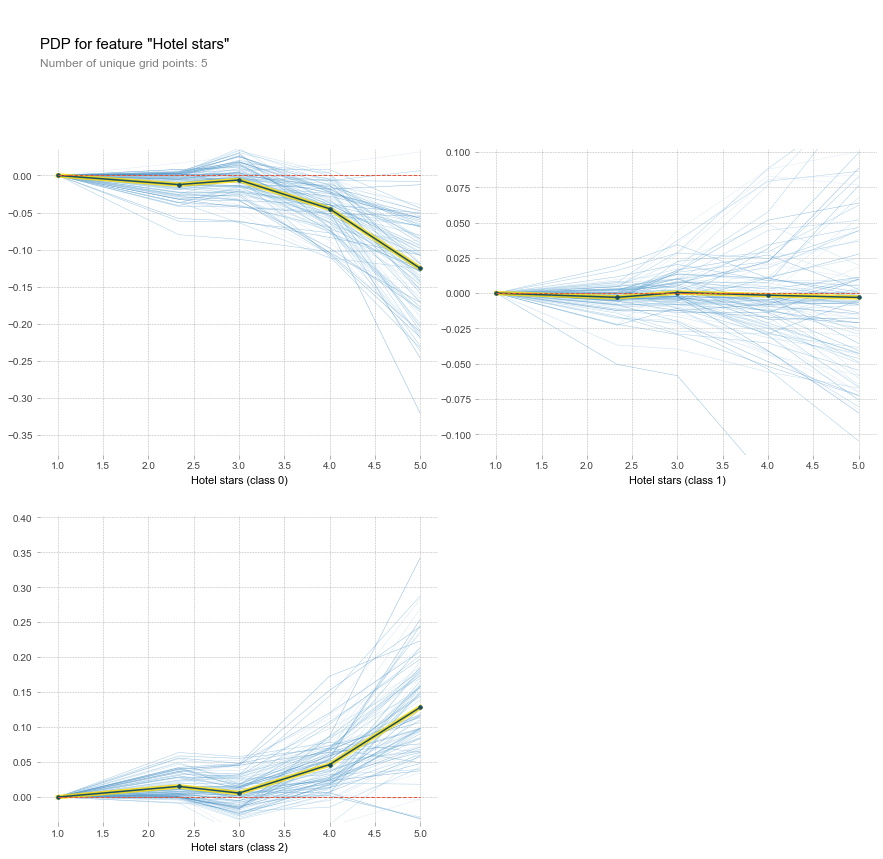

In [429]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'Hotel stars'

isolated = pdp_isolate(
    model=forest_pipeline,
    dataset=X_test,
    model_features=X_test.columns,
    feature=feature
    )

pdp_plot(isolated,feature_name=feature, plot_lines=True);

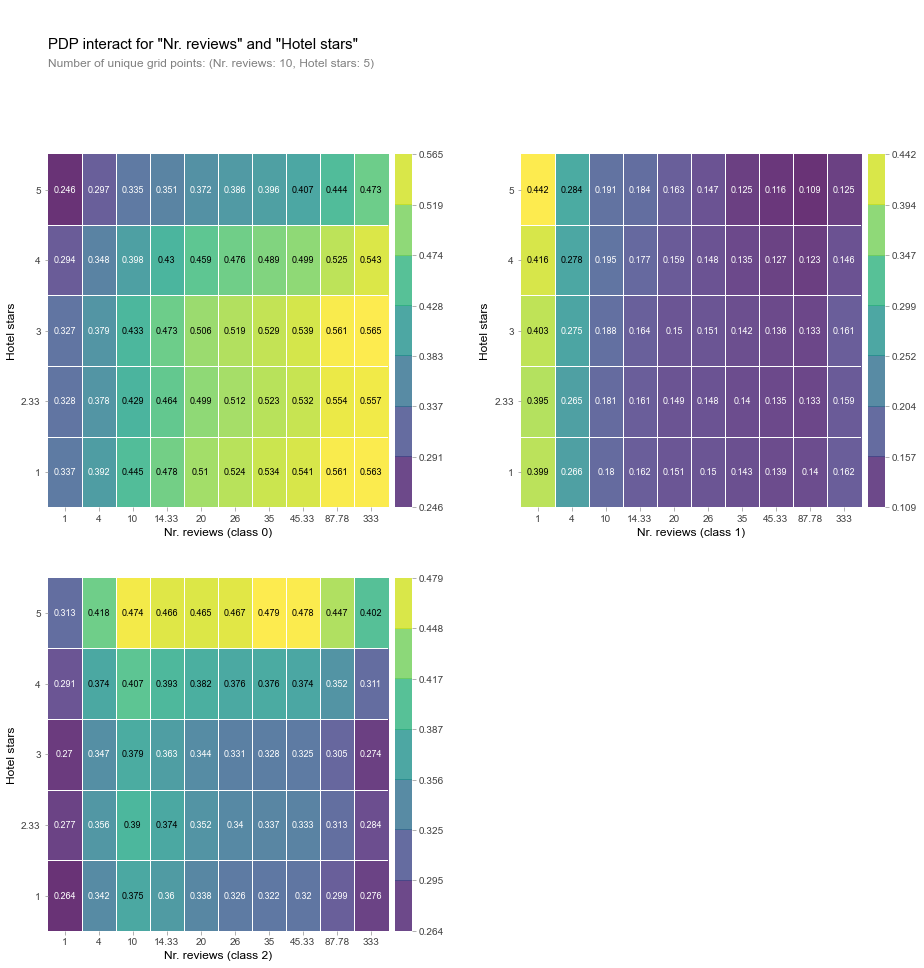

In [430]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

features_interact = ['Nr. reviews', 'Hotel stars']

interaction = pdp_interact(
    model=forest_pipeline,
    dataset=X_test,
    model_features=X_test.columns,
    features=features_interact
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features_interact);

In [431]:
#def predict_rating(num_reviews, num_hotel_reviews, helpful_votes, country, period_of_stay, traveler_type,
#                   hotel_name, continent, review_month, review_weekday):

In [432]:
user_input = [[75, 20, 15, "3.5", 1228, 'USA', 'Dec-Feb', 'Couples', 'YES', 'YES', 'NO', 'YES', 'YES', 'YES',
                      'Hilton Grand Vacations on the Boulevard', 'North America', 'November', 'Monday']]

df_user_input = pd.DataFrame(user_input, columns=features)
df_user_input = wrangle(df_user_input, predict=True)

In [433]:
voting_model.predict(df_user_input)

array(['Average'], dtype=object)

In [434]:
train.head()

,User country,Nr. reviews,Nr. hotel reviews,Helpful votes,Score,Period of stay,Traveler type,Pool,Gym,Tennis court,Spa,Casino,Free internet,Hotel name,Hotel stars,Nr. rooms,User continent,Review month,Review weekday
298,USA,9,3,4,Excellent,Jun-Aug,Friends,YES,YES,NO,YES,YES,YES,Hilton Grand Vacations on the Boulevard,2,1228,North America,June,Monday
251,USA,2,0,1,Excellent,Jun-Aug,Couples,YES,NO,NO,NO,YES,YES,The Cromwell,4,188,North America,June,Wednesday
163,UK,18,4,16,Excellent,Sep-Nov,Friends,YES,YES,NO,YES,YES,YES,The Cosmopolitan Las Vegas,5,2959,Europe,October,Friday
447,Other,102,25,37,Excellent,Jun-Aug,Families,YES,YES,NO,YES,YES,YES,Bellagio Las Vegas,5,3933,Europe,August,Sunday
43,Other,47,6,27,Average,Sep-Nov,Friends,YES,YES,NO,YES,YES,YES,Excalibur Hotel & Casino,1,3981,Europe,October,Monday


In [435]:
features

['Nr. reviews',
 'Nr. hotel reviews',
 'Helpful votes',
 'Hotel stars',
 'Nr. rooms',
 'User country',
 'Period of stay',
 'Traveler type',
 'Pool',
 'Gym',
 'Tennis court',
 'Spa',
 'Casino',
 'Free internet',
 'Hotel name',
 'User continent',
 'Review month',
 'Review weekday']

In [436]:
df_user_input

,Nr. reviews,Nr. hotel reviews,Helpful votes,Hotel stars,Nr. rooms,User country,Period of stay,Traveler type,Pool,Gym,Tennis court,Spa,Casino,Free internet,Hotel name,User continent,Review month,Review weekday
0,75,20,15,2,1228,USA,Dec-Feb,Couples,YES,YES,NO,YES,YES,YES,Hilton Grand Vacations on the Boulevard,North America,November,Monday


In [437]:
train['Hotel name'].value_counts()

The Cosmopolitan Las Vegas                             23
Paris Las Vegas                                        22
Tuscany Las Vegas Suites & Casino                      22
Marriott's Grand Chateau                               21
Tropicana Las Vegas - A Double Tree by Hilton Hotel    21
The Westin las Vegas Hotel Casino & Spa                21
Hilton Grand Vacations on the Boulevard                21
Caesars Palace                                         20
Wyndham Grand Desert                                   20
Monte Carlo Resort&Casino                              20
Hilton Grand Vacations at the Flamingo                 19
The Cromwell                                           19
Encore at wynn Las Vegas                               18
Bellagio Las Vegas                                     18
The Venetian Las Vegas Hotel                           18
Wynn Las Vegas                                         18
The Palazzo Resort Hotel Casino                        17
Trump Internat

In [438]:
train[train['Hotel name'] == "Circus Circus Hotel & Casino Las Vegas"]

,User country,Nr. reviews,Nr. hotel reviews,Helpful votes,Score,Period of stay,Traveler type,Pool,Gym,Tennis court,Spa,Casino,Free internet,Hotel name,Hotel stars,Nr. rooms,User continent,Review month,Review weekday
10,USA,102,24,58,Bad,Jun-Aug,Families,NO,YES,NO,NO,YES,YES,Circus Circus Hotel & Casino Las Vegas,1,3773,North America,June,Friday
5,Canada,31,8,27,Average,Mar-May,Couples,NO,YES,NO,NO,YES,YES,Circus Circus Hotel & Casino Las Vegas,1,3773,North America,March,Tuesday
22,UK,18,7,19,Average,Dec-Feb,Families,NO,YES,NO,NO,YES,YES,Circus Circus Hotel & Casino Las Vegas,1,3773,Europe,December,Saturday
6,UK,45,12,46,Average,Mar-May,Couples,NO,YES,NO,NO,YES,YES,Circus Circus Hotel & Casino Las Vegas,1,3773,Europe,April,Friday
23,USA,4,4,3,Bad,Dec-Feb,Couples,NO,YES,NO,NO,YES,YES,Circus Circus Hotel & Casino Las Vegas,1,3773,North America,December,Sunday
16,Canada,8,8,9,Bad,Sep-Nov,Families,NO,YES,NO,NO,YES,YES,Circus Circus Hotel & Casino Las Vegas,1,3773,North America,September,Wednesday
21,Other,4,3,3,Bad,Sep-Nov,Couples,NO,YES,NO,NO,YES,YES,Circus Circus Hotel & Casino Las Vegas,1,3773,Oceania,November,Monday
9,Canada,12,7,11,Average,Mar-May,Families,NO,YES,NO,NO,YES,YES,Circus Circus Hotel & Casino Las Vegas,1,3773,North America,May,Tuesday
14,UK,3,3,0,Average,Jun-Aug,Friends,NO,YES,NO,NO,YES,YES,Circus Circus Hotel & Casino Las Vegas,1,3773,Europe,August,Sunday
1,USA,119,21,75,Average,Dec-Feb,Business,NO,YES,NO,NO,YES,YES,Circus Circus Hotel & Casino Las Vegas,1,3773,North America,January,Friday
